# Learning with feedback

March 6, 2022

* How does feedback affect learning? 

* Under what conditions does it speed up learning? 

* And does it matter whether the feedback is aligned with the internal model?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d


# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories, plot_loss

### Train RNN on four targets using RFLO

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1 `W_fb ~= W_m = W_bmi`

71it [00:00, 285.23it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7facc24d4b88>


1000it [00:02, 461.86it/s]
1000it [00:02, 465.69it/s]


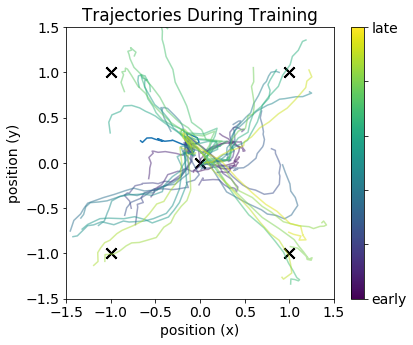

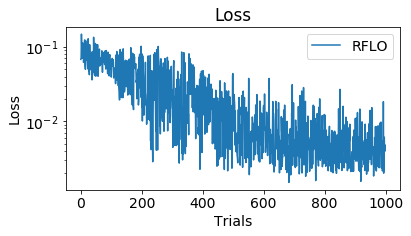

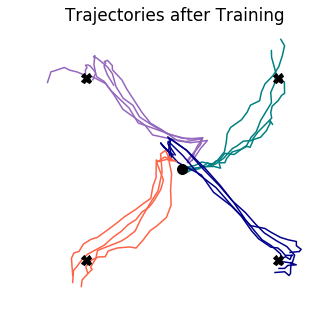

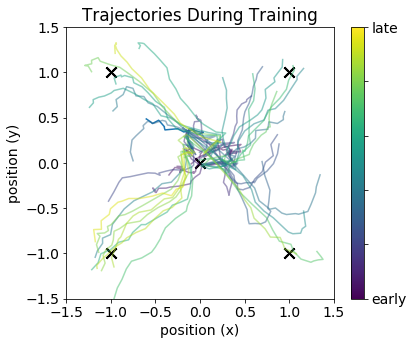

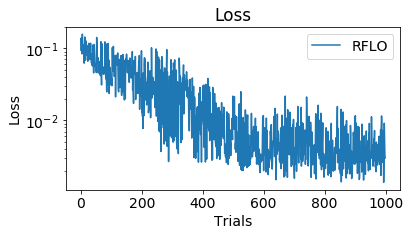

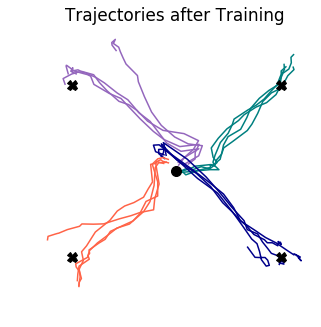

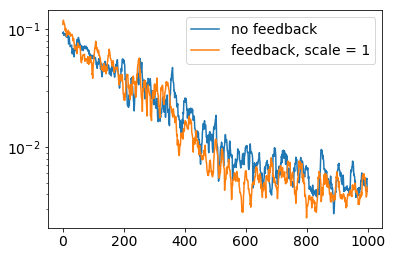

1000it [00:02, 486.79it/s]


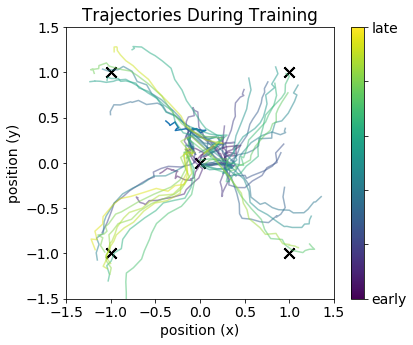

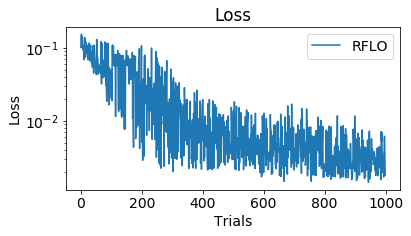

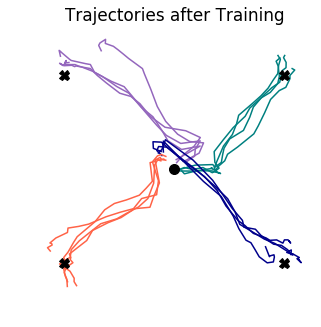

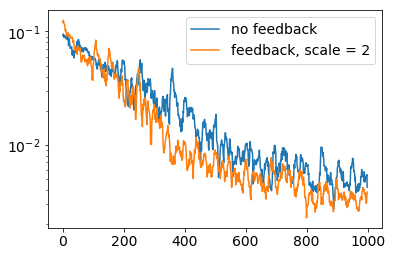

1000it [00:02, 483.15it/s]


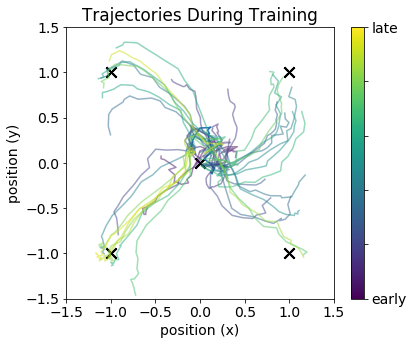

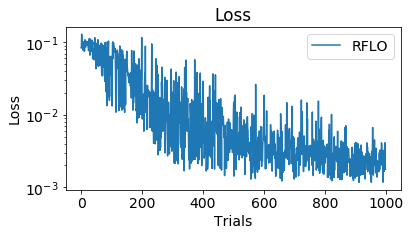

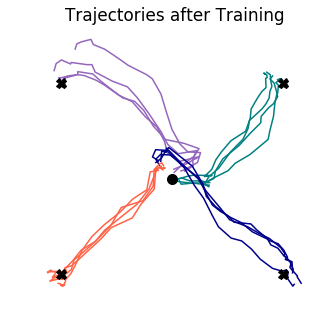

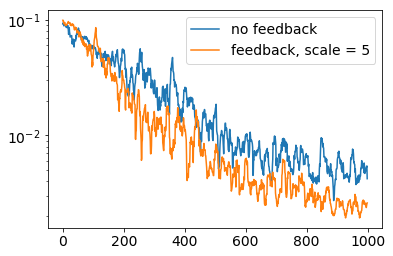

1000it [00:02, 482.69it/s]


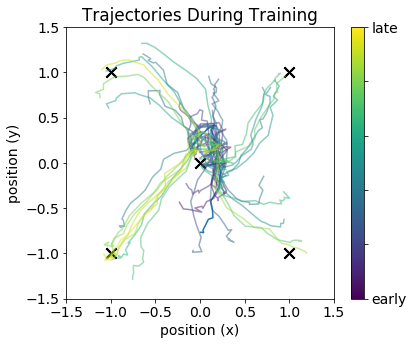

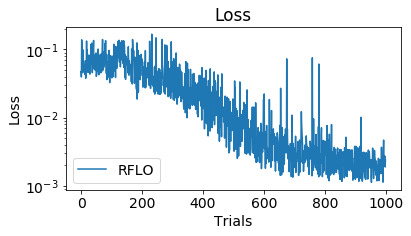

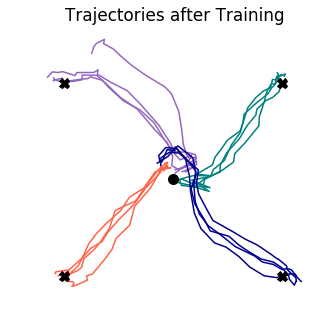

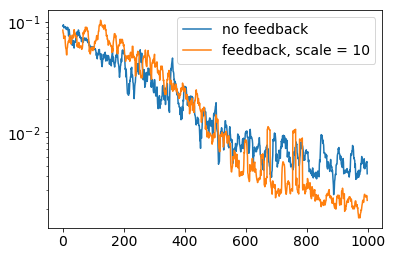

1000it [00:02, 484.67it/s]


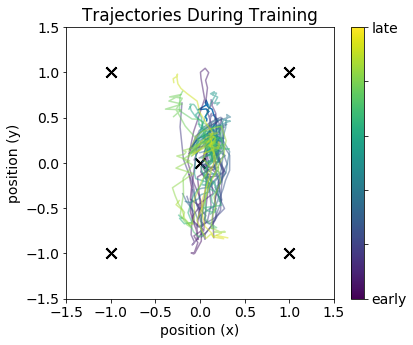

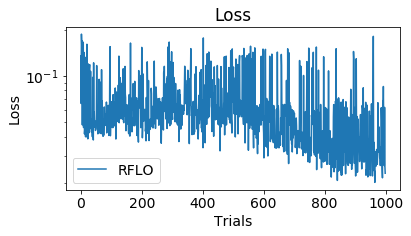

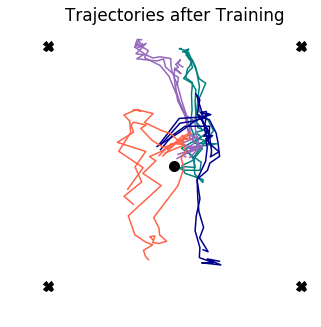

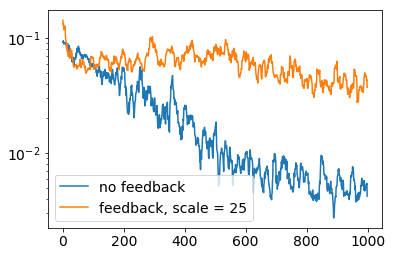

1000it [00:02, 468.23it/s]


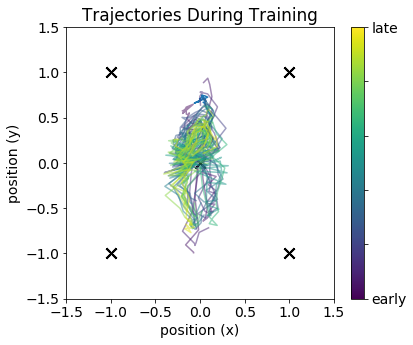

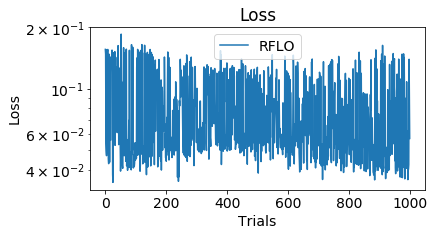

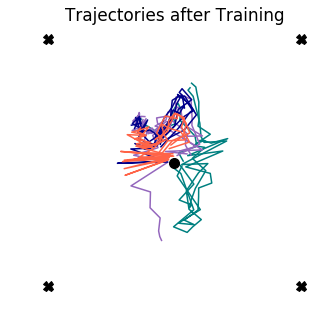

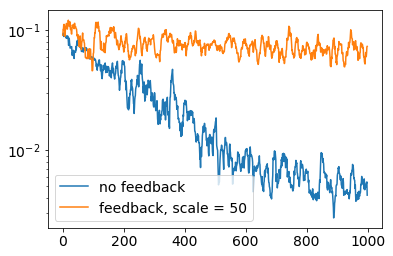

In [7]:
# Set RNN Parameters
params0 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=False,
               rng=np.random.RandomState(1))

params1 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(1))

params0.print_params()
#params1.print_params()

""" No Feedback """
# Initialize RNN
net0 = RNN(params0)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net0,apply_to=['w_rec'],online=False) 


sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','err','loss'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

loss_list = []

fb_scale = [1,2,5,10,25,50]
for i,scale in enumerate(fb_scale):

    """ with feedback """
    # Initialize RNN
    net1 = RNN(params1)
    net1.set_weights(w_fb = scale*np.copy(net1.w_fb))

    # initialize simulation
    sim1 = Simulation(net1)

    # instantiate learning algorithm
    # Specify particular matrix/unit to apply algorithm
    rflo = RFLO(net1,apply_to=['w_rec'],online=False) 


    sim1.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=25)

    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])
    plt.show()

    from scipy.ndimage.filters import uniform_filter1d

    """ Plot Loss with moving average """
    av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),10)
    plt.plot(av0,label='no feedback')
    av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),10)
    plt.plot(av1,label='feedback, scale = {}'.format(scale))
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    if i == 0:
        loss_list.append(av0)
    
    loss_list.append(av1)


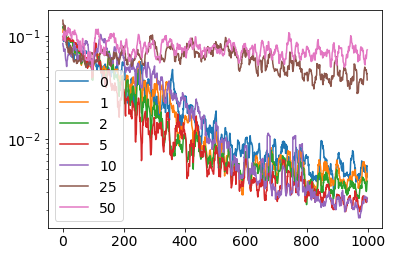

In [61]:
fb_scale = [0,1,2,5,10,25,50]
""" Plot Loss with moving average """
for i,av in enumerate(loss_list):
        plt.plot(av,label=fb_scale[i])

plt.yscale('log')
plt.legend()
plt.show()

## 1A `W_fb = W_m = W_bmi`

1000it [00:02, 341.56it/s]
1000it [00:02, 369.19it/s]


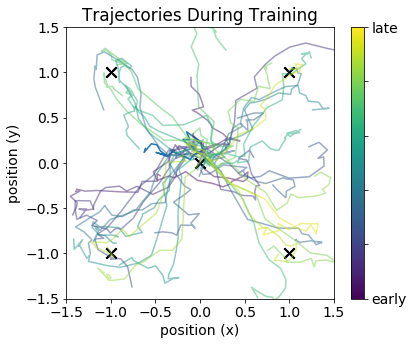

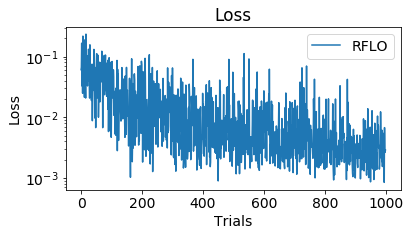

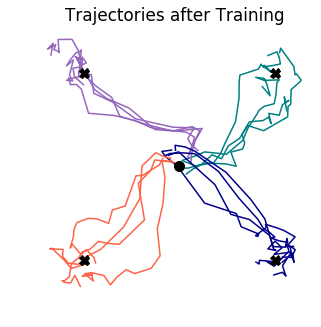

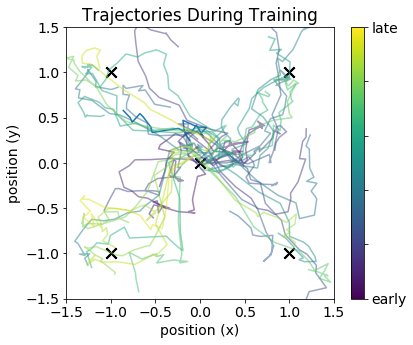

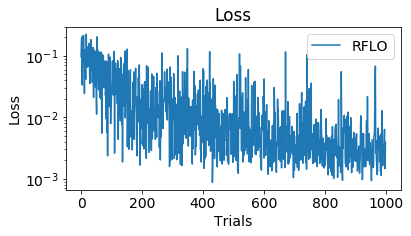

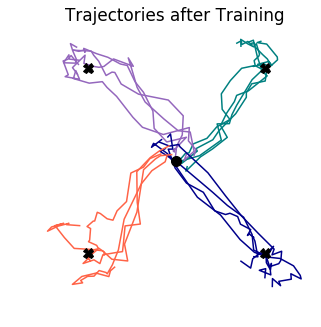

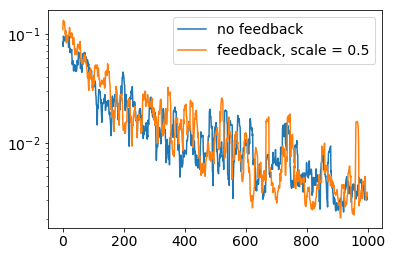

1000it [00:02, 347.83it/s]


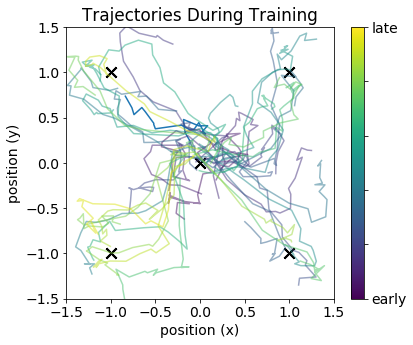

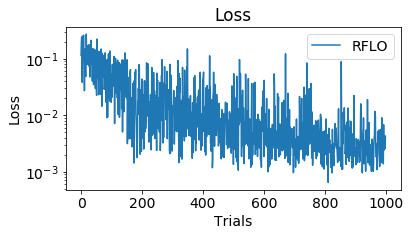

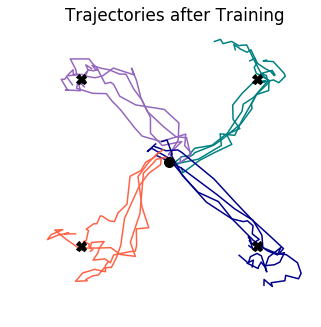

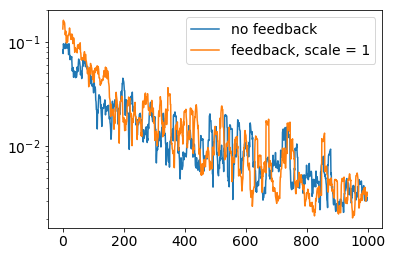

1000it [00:02, 347.98it/s]


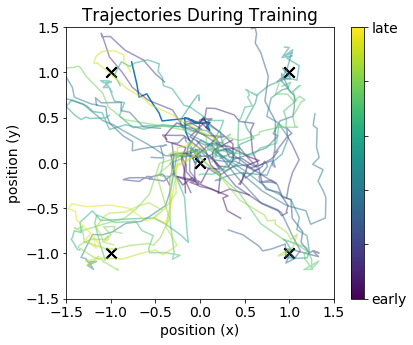

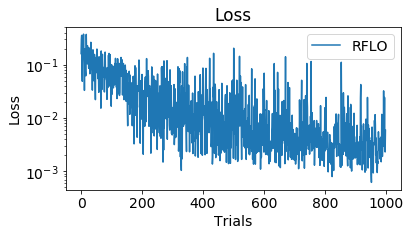

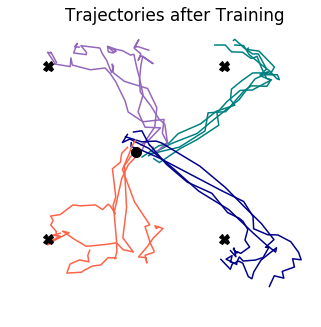

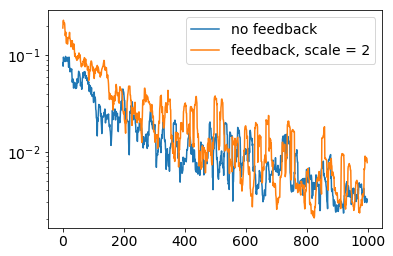

1000it [00:02, 374.41it/s]


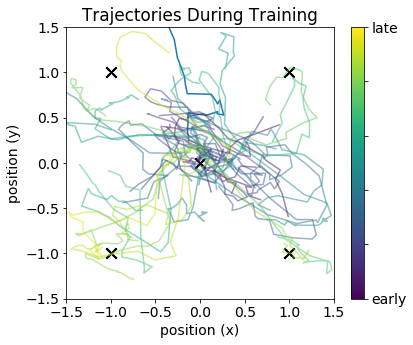

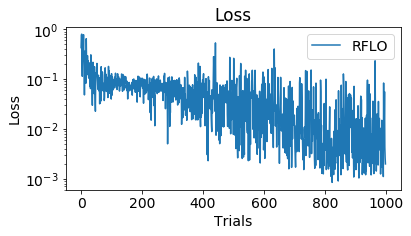

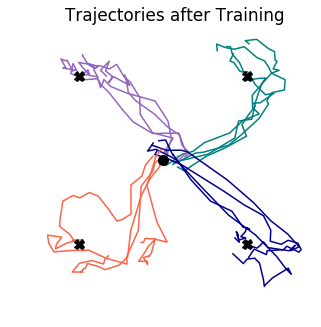

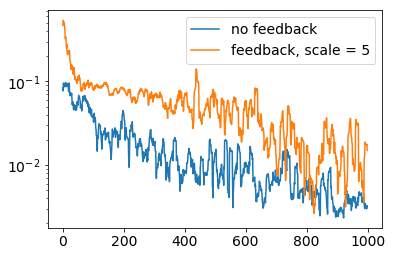

1000it [00:02, 357.66it/s]


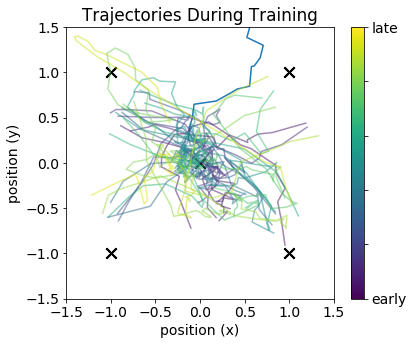

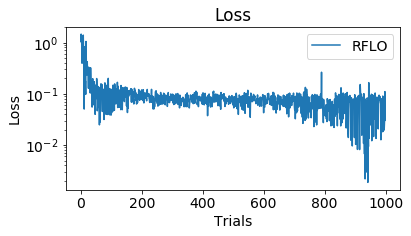

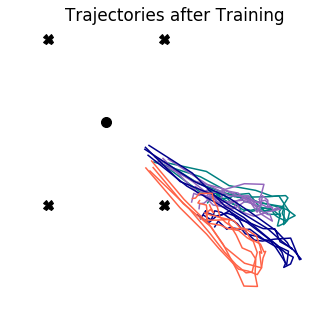

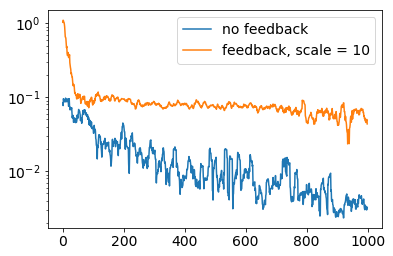

1000it [00:02, 361.60it/s]


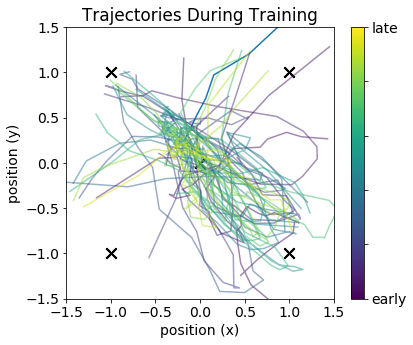

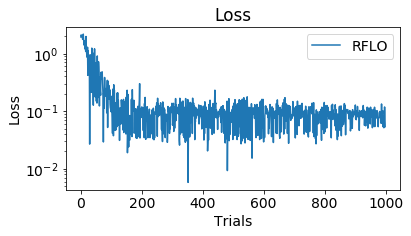

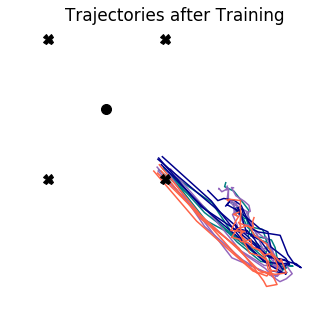

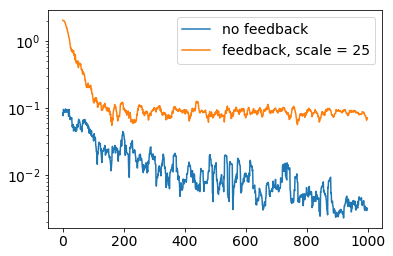

In [7]:
# Set RNN Parameters
params0 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.5,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=False,
               rng=np.random.RandomState(1))

params1 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.5,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,feedback_signal='error', #note error and not position here
               rng=np.random.RandomState(1))

#params0.print_params()
#params1.print_params()

""" No Feedback """
# Initialize RNN
net0 = RNN(params0)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net0,apply_to=['w_rec'],online=False) 


sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','err','loss'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

loss_list = []

fb_scale = [0.5,1,2,5,10]
for i,scale in enumerate(fb_scale):

    """ with feedback """
    # Initialize RNN
    net1 = RNN(params1)
    net1.set_weights(w_fb = scale*np.copy(net1.w_out.T)) # note that feedback here is same as w_m

    # initialize simulation
    sim1 = Simulation(net1)

    # instantiate learning algorithm
    # Specify particular matrix/unit to apply algorithm
    rflo = RFLO(net1,apply_to=['w_rec'],online=False) 


    sim1.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=25)

    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])
    plt.show()


    """ Plot Loss with moving average """
    av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),10)
    plt.plot(av0,label='no feedback')
    av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),10)
    plt.plot(av1,label='feedback, scale = {}'.format(scale))
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    if i == 0:
        loss_list.append(av0)
    
    loss_list.append(av1)


# Gaussian readout

31it [00:00, 305.38it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.0
sig_out: 0.0
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: 0.1
sig_fb: 0.0
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7facc2316750>


1000it [00:02, 406.38it/s]
1000it [00:02, 357.68it/s]


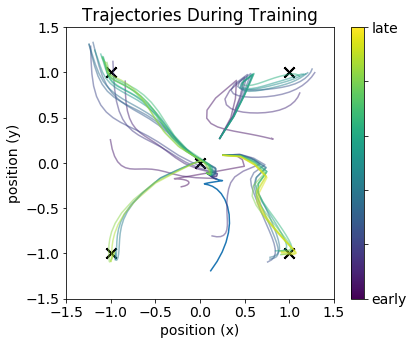

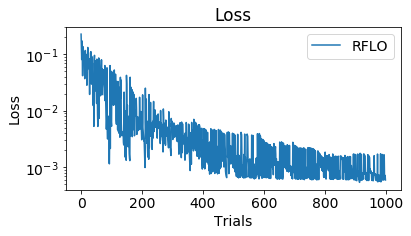

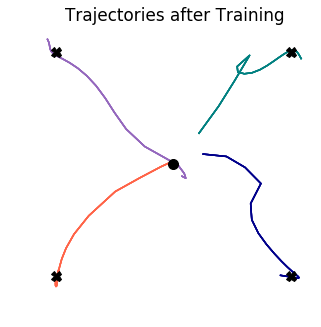

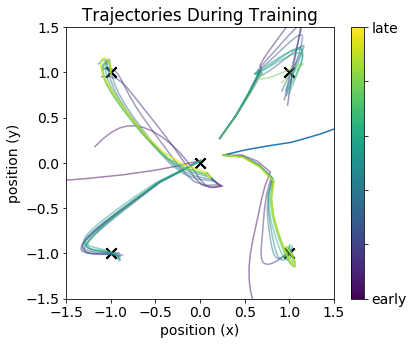

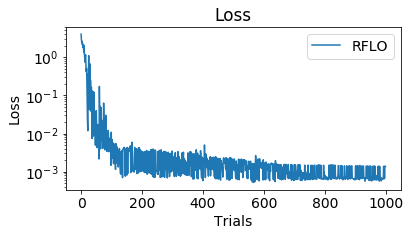

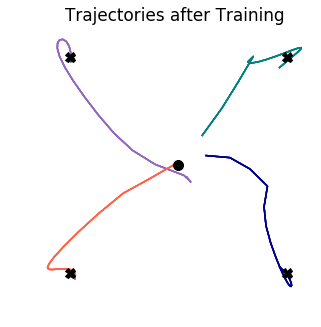

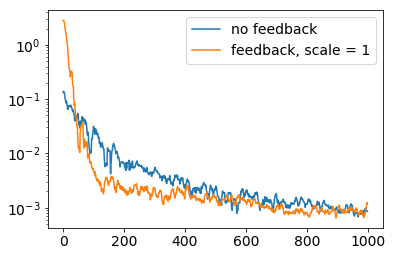

1000it [00:03, 322.52it/s]


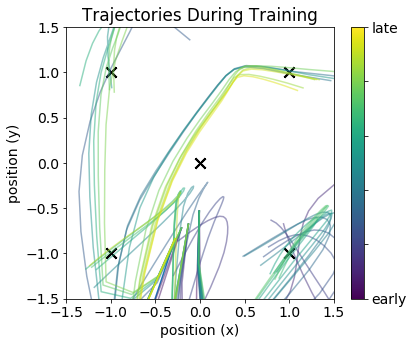

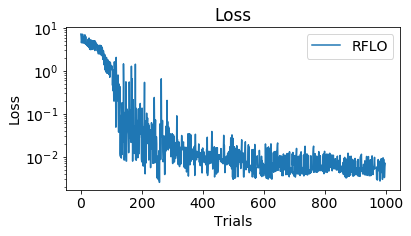

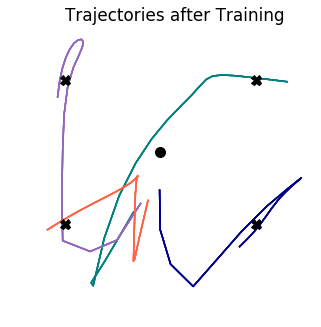

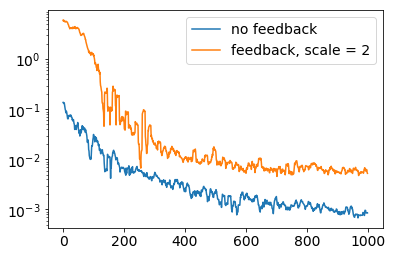

1000it [00:02, 484.95it/s]


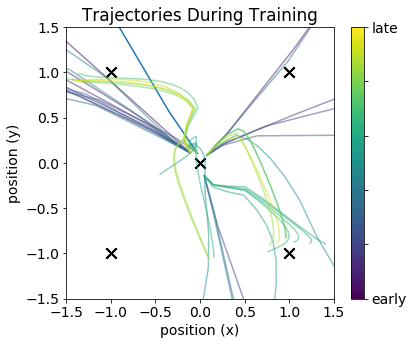

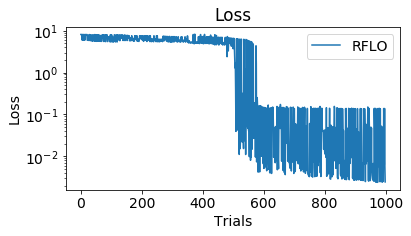

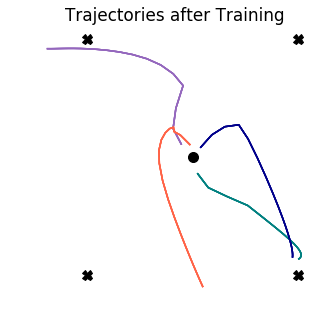

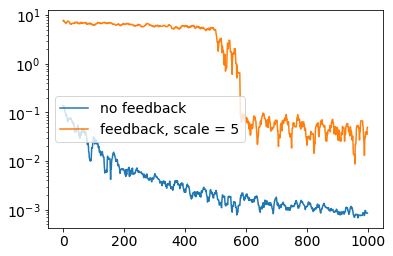

1000it [00:02, 484.48it/s]


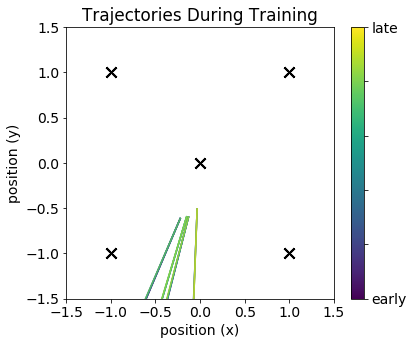

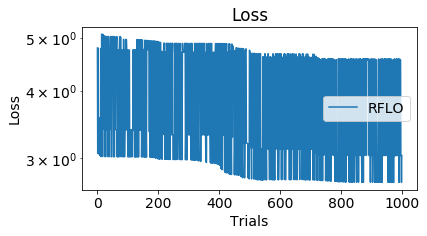

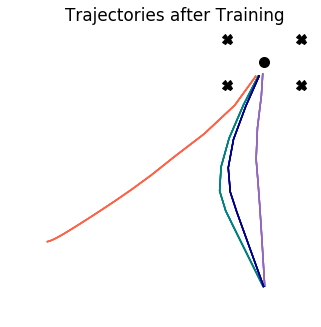

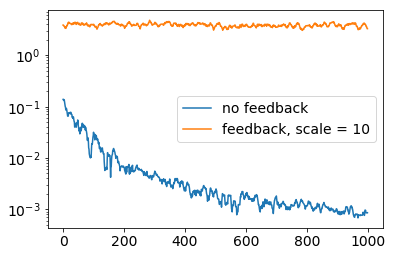

In [22]:
# 2*self.rng.randn(self.n_rec,self.n_out)/self.n_rec**0.5

# Set RNN Parameters
params0 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.0,sig_out=0.0,sig_fb=0.0,
               velocity_transform=False,
               driving_feedback=False,
               rng=np.random.RandomState(22))

params1 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.0,sig_out=0.0,sig_fb=0.0,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(22))

params0.print_params()
#params1.print_params()

""" No Feedback """
# Initialize RNN
net0 = RNN(params0)
net0.set_weights(w_out = 2*params0.rng.randn(params0.n_out,params0.n_rec)/params0.n_rec**0.5)
net0.set_weights(w_m = net0.w_out.T)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net0,apply_to=['w_rec'],online=False) 


sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','err','loss'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

loss_list = []

fb_scale = [1,2,5,10]#,10,25,50]
for i,scale in enumerate(fb_scale):

    """ with feedback """
    # Initialize RNN
    net1 = RNN(params1)
    net1.set_weights(w_out = 2*params1.rng.randn(params1.n_out,params1.n_rec)/params1.n_rec**0.5)
    net1.set_weights(w_m = net1.w_out.T)
    net1.set_weights(w_fb = scale*np.copy(net1.w_out.T)) # note that feedback here is same as w_m
    #net1.set_weights(w_fb = scale*(2*params1.rng.randn(params1.n_out,params1.n_rec)/params1.n_rec**0.5).T) # note that feedback here is same as w_m

    # initialize simulation
    sim1 = Simulation(net1)

    # instantiate learning algorithm
    # Specify particular matrix/unit to apply algorithm
    rflo = RFLO(net1,apply_to=['w_rec'],online=False) 


    sim1.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=25)

    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])
    plt.show()

    """ Plot Loss with moving average """
    av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),10)
    plt.plot(av0,label='no feedback')
    av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),10)
    plt.plot(av1,label='feedback, scale = {}'.format(scale))
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    if i == 0:
        loss_list.append(av0)
    
    loss_list.append(av1)


# REINFORCE

Will random feedback be better than aligned (driving) feedback?

In [7]:
trial_duration = 20
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

79it [00:00, 346.50it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
driving_feedback: False
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7ff8807793a8>


10000it [00:21, 472.64it/s]
10000it [00:21, 456.29it/s]


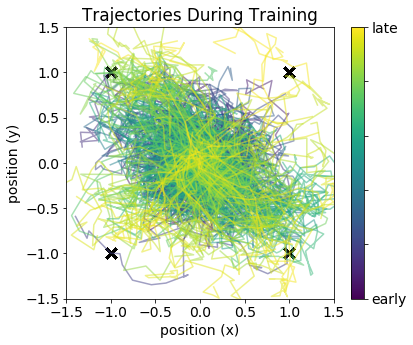

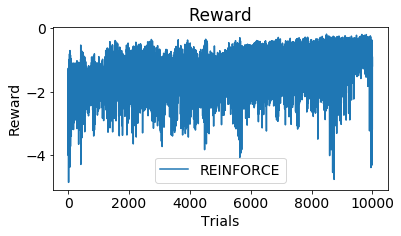

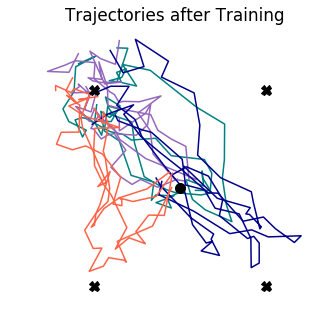

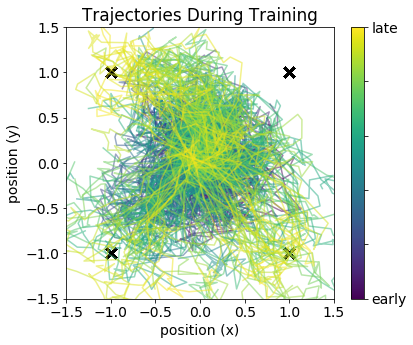

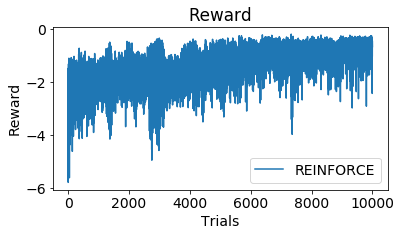

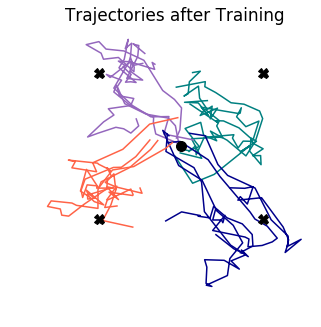

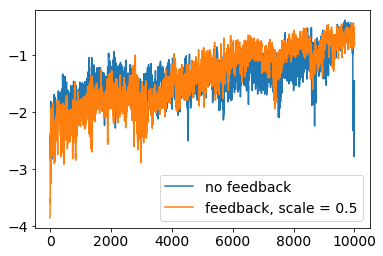

10000it [00:25, 393.63it/s]


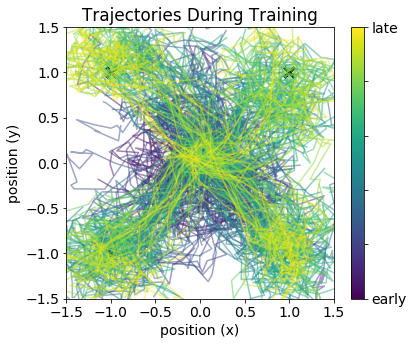

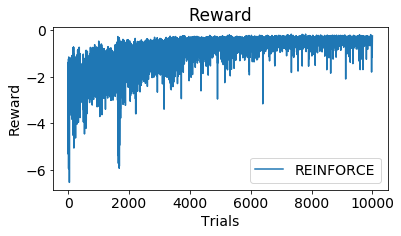

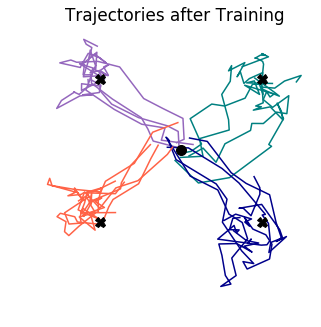

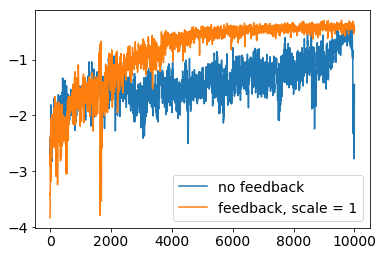

10000it [00:22, 448.59it/s]


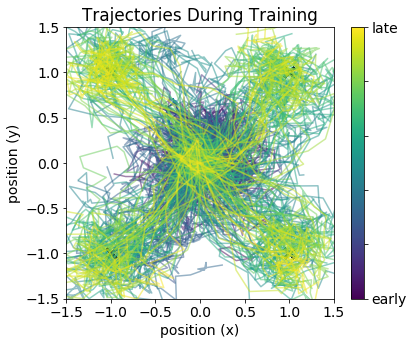

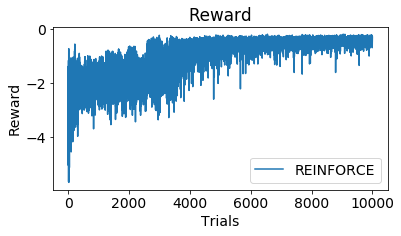

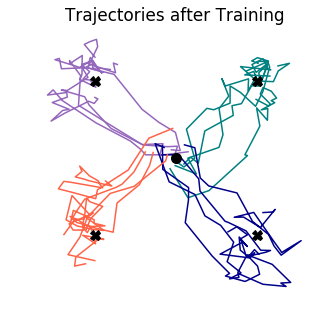

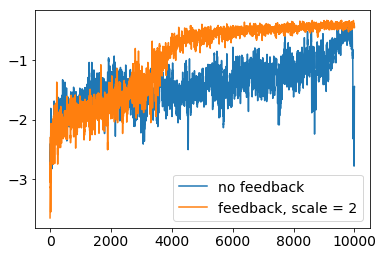

10000it [00:23, 419.84it/s]


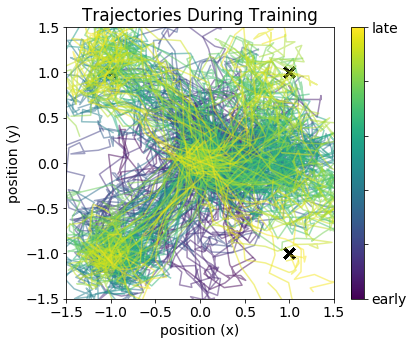

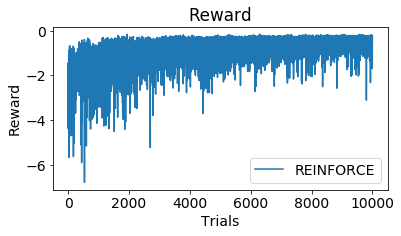

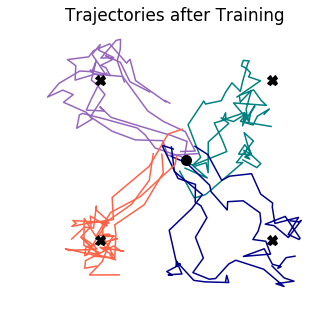

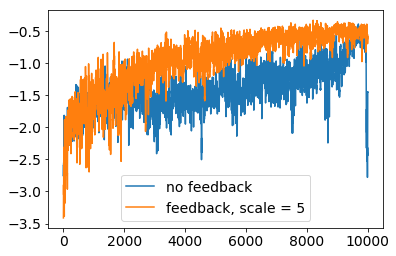

In [10]:
# Set RNN Parameters
params0 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.5,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=False,
               rng=np.random.RandomState(1))

params1 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.5,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(1))

params0.print_params()
#params1.print_params()

""" No Feedback """
# Initialize RNN
net0 = RNN(params0)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
#rflo = RFLO(net0,apply_to=['w_rec'],online=False) 
reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned



sim0.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','err','reward'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

loss_list = []

fb_scale = [0.5,1,2,5]#,10]#,25,50]
for i,scale in enumerate(fb_scale):

    """ with feedback """
    # Initialize RNN
    net1 = RNN(params1)
    net1.set_weights(w_fb = scale*np.copy(net1.w_fb)) # note feedback is random

    # initialize simulation
    sim1 = Simulation(net1)

    # instantiate learning algorithm
    # Specify particular matrix/unit to apply algorithm
    #rflo = RFLO(net1,apply_to=['w_rec'],online=False) 
    reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned



    sim1.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=25)

    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])
    plt.show()


    """ Plot Loss with moving average """
    av0 = uniform_filter1d(np.mean(sim0.session_probes['reward'],axis=1),10)
    plt.plot(av0,label='no feedback')
    av1 = uniform_filter1d(np.mean(sim1.session_probes['reward'],axis=1),10)
    plt.plot(av1,label='feedback, scale = {}'.format(scale))
    plt.legend()
    plt.show()
    
    if i == 0:
        loss_list.append(av0)
    
    loss_list.append(av1)


## Feedback aligned with readout...

37it [00:00, 365.54it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.5
eta_out: 0.1
driving_feedback: False
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
rng: <mtrand.RandomState object at 0x7ff87a319510>


10000it [00:20, 484.92it/s]
10000it [00:20, 490.04it/s]


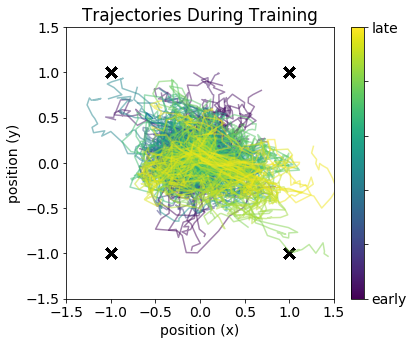

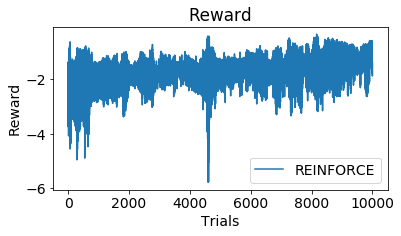

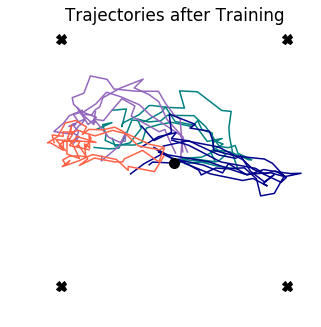

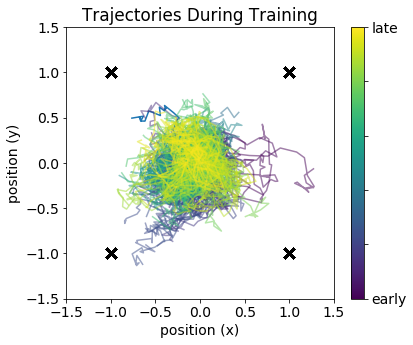

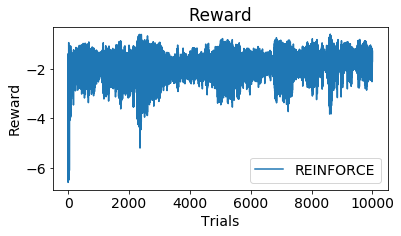

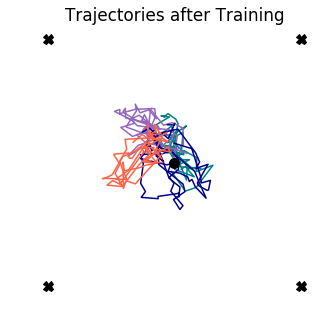

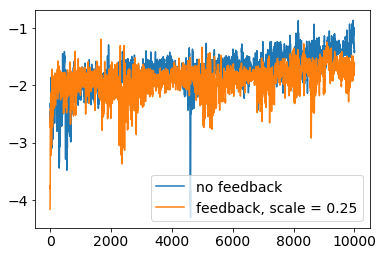

10000it [00:22, 438.05it/s]


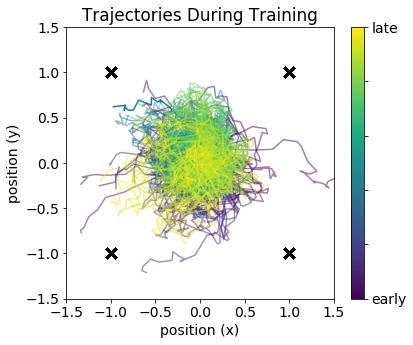

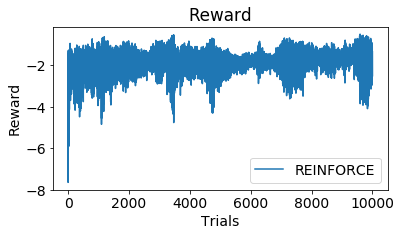

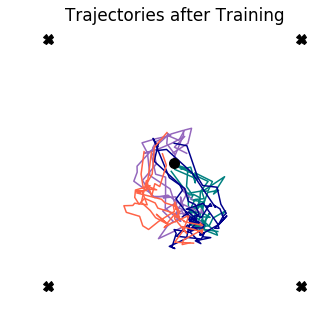

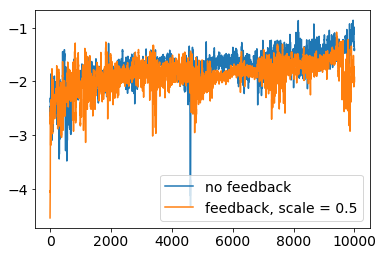

10000it [00:20, 492.28it/s]


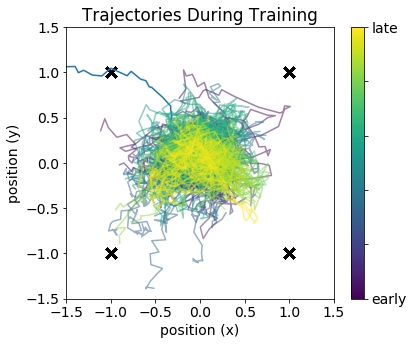

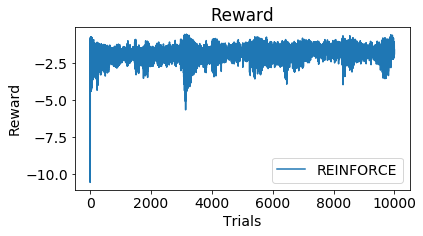

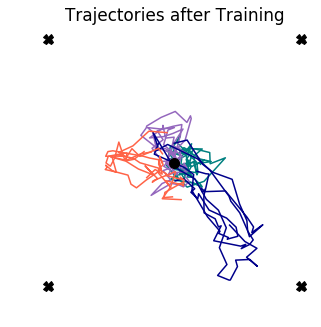

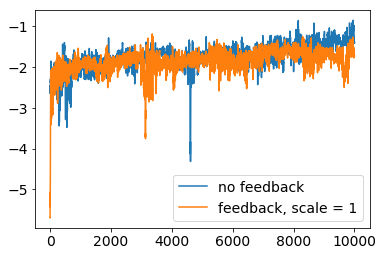

10000it [00:27, 363.97it/s]


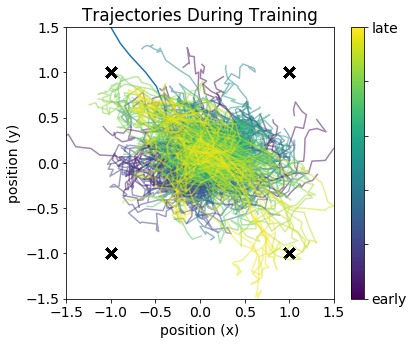

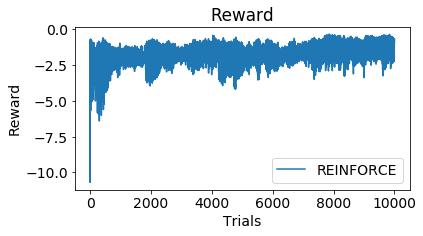

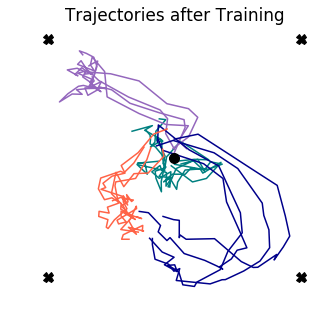

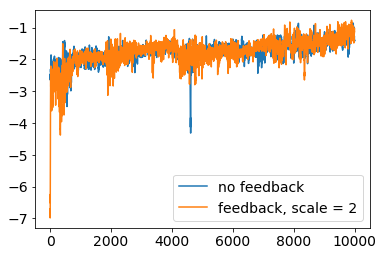

In [17]:
# Set RNN Parameters
params0 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.1, # instead of 0.1,0.25
               sig_in=0.0,sig_rec=0.5,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=False,
               rng=np.random.RandomState(1))

params1 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.5,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(1))

params0.print_params()
#params1.print_params()

""" No Feedback """
# Initialize RNN
net0 = RNN(params0)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
#rflo = RFLO(net0,apply_to=['w_rec'],online=False) 
reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned



sim0.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','err','reward'], plot=True, plot_freq=25)

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

loss_list = []

fb_scale = [0.25,0.5,1,2]#5,10]#,25,50]
for i,scale in enumerate(fb_scale):

    """ with feedback """
    # Initialize RNN
    net1 = RNN(params1)
    net1.set_weights(w_fb = scale*np.copy(net1.w_out.T)) # note that feedback here is same as w_m


    # initialize simulation
    sim1 = Simulation(net1)

    # instantiate learning algorithm
    # Specify particular matrix/unit to apply algorithm
    #rflo = RFLO(net1,apply_to=['w_rec'],online=False) 
    reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5) # weight transport only applies when w_out is being learned



    sim1.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=25)

    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])
    plt.show()


    """ Plot Loss with moving average """
    av0 = uniform_filter1d(np.mean(sim0.session_probes['reward'],axis=1),10)
    plt.plot(av0,label='no feedback')
    av1 = uniform_filter1d(np.mean(sim1.session_probes['reward'],axis=1),10)
    plt.plot(av1,label='feedback, scale = {}'.format(scale))
    plt.legend()
    plt.show()
    
    if i == 0:
        loss_list.append(av0)
    
    loss_list.append(av1)


## 1B `W_fb = W_m`, aligned with `W_bmi`

## 1C `W_fb = W_m`, not aligned with `W_bmi`

## 1D `W_m` aligned with  `W_bmi`,  `W_fb = W_bmi`

## 1E `W_m` aligned with  `W_bmi`,  `W_fb` not aligned `W_bmi`

## 1F `W_fb ~= W_m`